In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from easymoney.money import EasyPeasy # For normalizing money
from dateutil import parser # for date conversion

import matplotlib.pyplot as plt
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline
from pprint import pprint

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, learning_curve, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest

#from common.CommonFunctions import train_and_eval

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data_orig = pd.read_csv('./data/train.csv')

data = data_orig.copy()
data[['release_date']] = data_orig['release_date'].map(parser.parse)
data['release_year'] = pd.DatetimeIndex(data_orig['release_date']).year
data['release_month'] = pd.DatetimeIndex(data_orig['release_date']).month_name()
data['release_day'] = pd.DatetimeIndex(data_orig['release_date']).day_name()

# date parser interprets 21 to 68 as 2021 to 2068 --> fix
data.loc[data.release_year >= 2021, 'release_year'] = data.loc[data.release_year >= 2021, 'release_year'] - 100


In [20]:
# Off topic -> Normalize budget (remove inflation) -> basically no effect
def normalize_budget(ep, budget, region, from_year):
    region = region
    from_year = from_year
    to_year = "latest"
    base_currency = "USD"
    return int(ep.normalize(amount=budget, region=region, from_year=from_year, to_year=to_year, base_currency=base_currency))

# ep = EasyPeasy()
# data['norm_budget'] = data.apply(lambda row: normalize_budget(ep=ep, budget=row['budget'], region='USA', from_year=row['release_year']), axis=1)

In [68]:
tmp = data[['budget', 'release_year']][data.budget != 0]
median_budgets_per_year = tmp.groupby('release_year').agg(np.median).reset_index().rename(columns = {'budget': 'median_budget'})

In [71]:
tmp = data.merge(median_budgets_per_year, on=['release_year'], how='left')
data_filled = tmp.copy()
data_filled['budget'] = data_filled['budget'].replace(to_replace=0, value=data_filled['median_budget']).fillna(0)

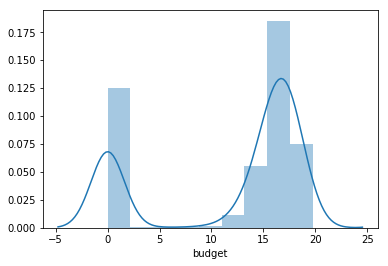

In [72]:
sns.distplot(np.log1p(data.budget))

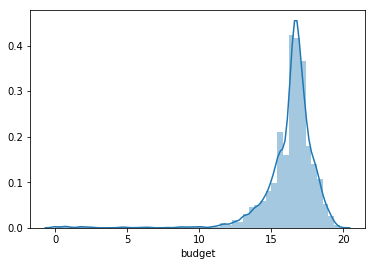

In [73]:
sns.distplot(np.log1p(data_filled.budget))

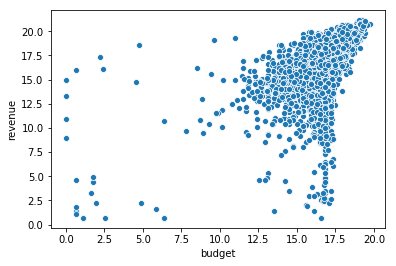

In [74]:
sns.scatterplot(np.log1p(data_filled.budget), np.log1p(data_filled.revenue))

In [82]:
np.corrcoef(np.log1p(data_filled.budget), np.log1p(data_filled.revenue))

array([[1.        , 0.43672347],
       [0.43672347, 1.        ]])

In [97]:
data_logged = np.log1p(data_filled[['budget', 'revenue']])

q75, q25 = np.percentile(data_logged.budget, [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*3)
max = q75 + (iqr*3)

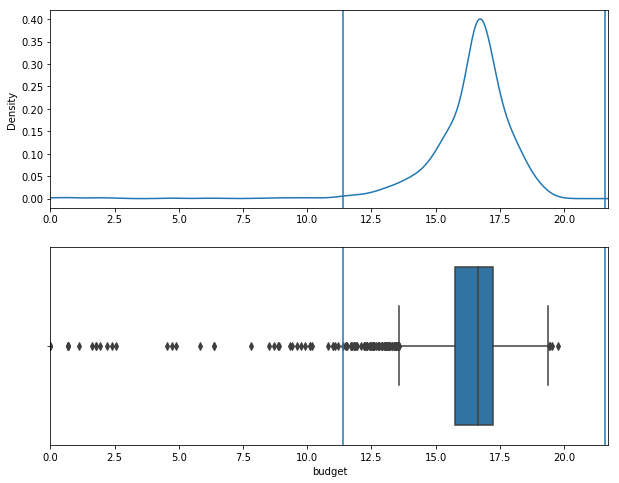

In [98]:
i = 'budget'
df = data_logged
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i])
plt.axvline(x=min)
plt.axvline(x=max)

In [107]:
print("Number of extreme outliers in budget: {}".format(len(data_filled[(np.log1p(data_filled.budget) > max) | (np.log1p(data_filled.budget) < min)])))
data_filled[(np.log1p(data_filled.budget) > max) | (np.log1p(data_filled.budget) < min)]

Number of extreme outliers in budget: 41


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,tagline,title,Keywords,cast,crew,revenue,release_year,release_month,release_day,median_budget
254,255,NaN,11178.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt2244376,en,Bwakaw,"Bwakaw is a drama-comedy about growing old, an...",0.079287,...,"In life, you only need one true friend.",Voracious,"[{'id': 4694, 'name': 'staged death'}, {'id': ...","[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'credit_id': '52fe4a5cc3a368484e14eef3', 'de...",34659,2012,September,Wednesday,20000000.0
259,260,NaN,24554.0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0169302,en,Theeviravaathi: The Terrorist,A young female terrorist goes on a suicide ass...,0.154526,...,Her death will not be ordinary.,The Terrorist,NaN,"[{'cast_id': 2, 'character': 'Malli', 'credit_...","[{'credit_id': '52fe475bc3a36847f813138f', 'de...",140021,1998,September,Saturday,25000000.0
267,268,"[{'id': 182813, 'name': 'Clerks Collection', '...",27000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.miramax.com/movie/clerks/,tt0109445,en,Clerks,Convenience and video store clerks Dante and R...,10.513367,...,Just because they serve you doesn't mean they ...,Clerks,"[{'id': 1361, 'name': 'salesclerk'}, {'id': 30...","[{'cast_id': 7, 'character': 'Dante Hicks', 'c...","[{'credit_id': '52fe434ac3a36847f8049259', 'de...",3151130,1994,September,Tuesday,20500000.0
333,334,NaN,0.0,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",NaN,tt0041996,en,Twelve O'Clock High,In this story of the early days of daylight bo...,2.870026,...,A story of twelve men as their women never kne...,Twelve O'Clock High,"[{'id': 1956, 'name': 'world war ii'}, {'id': ...","[{'cast_id': 1, 'character': 'Brigadier Genera...","[{'credit_id': '52fe46619251416c750766e3', 'de...",3225000,1949,December,Tuesday,NaN
334,335,NaN,1.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0376144,ta,Saamy,Saamy movie is all about Arusaamy (Vikram) who...,0.438490,...,NaN,Saamy,NaN,"[{'cast_id': 11, 'character': 'Aaruchamy', 'cr...","[{'credit_id': '52fe4782c3a36847f813999f', 'de...",3,2003,May,Monday,26000000.0
347,348,NaN,12.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,tt0118172,en,The Wind in the Willows,"Jailed for his reckless driving, rambunctious ...",1.410322,...,Go wild in the country!,The Wind in the Willows,NaN,"[{'cast_id': 2, 'character': 'Toad', 'credit_i...","[{'credit_id': '59ce7655c3a3686aca01a522', 'de...",1,1996,October,Wednesday,30500000.0
365,366,NaN,7000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://www.primermovie.com,tt0390384,en,Primer,Friends/fledgling entrepreneurs invent a devic...,7.153070,...,What happens if it actually works?,Primer,"[{'id': 1448, 'name': 'distrust'}, {'id': 2101...","[{'cast_id': 1, 'character': 'Aaron', 'credit_...","[{'credit_id': '52fe45e79251416c75066791', 'de...",424760,2004,October,Friday,21500000.0
469,470,"[{'id': 8580, 'name': 'The Karate Kid Collecti...",113.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",NaN,tt0091326,en,"The Karate Kid, Part II",Mr. Miyagi and Daniel take a trip to Okinawa t...,9.231318,...,"This time, the combat is real.","The Karate Kid, Part II","[{'id': 779, 'name': 'martial arts'}, {'id': 3...","[{'cast_id': 1, 'character': 'Daniel LaRusso',...","[{'credit_id': '52fe44c1c3a36847f80a82dd', 'de...",115103979,1986,June,Wednesday,13800000.0
508,509,NaN,60000.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...",http://www.pithemovie.com/,tt0138704,en,Pi,The debut film from Darren Aronofsky in which ...,10.621362,...,"There will be no order, only chaos",Pi,"[{'id': 2157, 'name': 'hacker'}, {'id': 2303, ...","[{'cast_id': 5, 'character': 'Maximillian Cohe...","[{'credit_id': '52fe4247c3a36847f8011f53', 'de...",3221152,1998,July,Friday,25000000.0
512,513,NaN,93.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://frompradatonadamovie.com/,tt0893412,en,From Prada to Nada,A whimsi